In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = {
    "train_batch_size": 5,
    "val_batch_size": 64,
    "in_channels": 3,
    "out_channels": 3,
    "num_downs": 7,
    "g_lr": 3e-4,
    "epochs_num": 1,
    "log_each": 10,
    "device": "cuda:1"
}

### EDA

In [3]:
DATA_DIR = '/home/pafakanov/data/other/dl/hw3/edges2shoes'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

In [4]:
def _get_paths(data_dir):
    filenames = os.listdir(data_dir)
    paths = [os.path.join(data_dir, name) for name in filenames]
    return paths

In [5]:
train_paths = _get_paths(TRAIN_DIR)
val_paths = _get_paths(VAL_DIR)

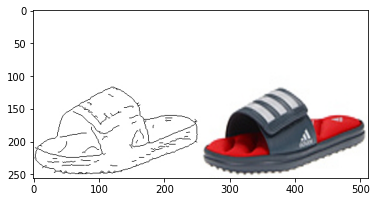

In [6]:
img = plt.imread(train_paths[0])
plt.imshow(img)

### Dataset

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [8]:
class ImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.transforms = transforms.Compose([
             transforms.ToTensor()
        ])

    def __len__(self):
        return len(os.listdir(self.data_dir)) - 1

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.data_dir, filename)
        img = Image.open(img_path)
        img_tensor = self.transforms(img)
        width = img_tensor.shape[2]
        sketch_tensor = img_tensor[:, :, :width//2]
        real_tensor = img_tensor[:, :, width//2:]
        return sketch_tensor.float(), real_tensor.float()

In [9]:
train_dataset = ImageDataset(TRAIN_DIR)
val_dataset = ImageDataset(VAL_DIR)

train_dataloader = DataLoader(train_dataset, config['train_batch_size'], True)
val_dataloader = DataLoader(val_dataset, config['val_batch_size'], True)

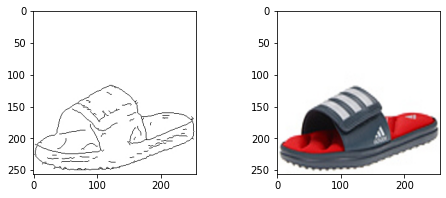

In [10]:
sketch, real = train_dataset[0]

f, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(sketch.permute(1, 2, 0))
ax[1].imshow(real.permute(1, 2, 0))
plt.show()

### Model

In [11]:
import functools

import torch
import torch.nn as nn

In [12]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)



In [13]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        result = self.model(input)
        result = torch.clamp(result, 0, 1)  # The valid range is from 0 to 1
        return result

In [14]:
generator = UnetGenerator(config['in_channels'], config['out_channels'], config['num_downs'])

In [15]:
generator(sketch.unsqueeze(0))

tensor([[[[0.0000, 0.0000, 0.0169,  ..., 0.0000, 0.0000, 0.4350],
          [0.0000, 0.7930, 0.0000,  ..., 0.9125, 0.0000, 0.0000],
          [0.6999, 0.0000, 0.0000,  ..., 0.0402, 0.0000, 0.0000],
          ...,
          [0.1841, 0.9579, 0.0000,  ..., 0.9399, 0.0000, 0.2376],
          [0.4396, 0.0000, 0.0000,  ..., 0.8102, 0.1589, 0.2160],
          [0.0000, 0.8799, 0.0000,  ..., 0.6721, 0.0000, 0.0000]],

         [[0.0667, 0.2515, 0.5151,  ..., 0.0000, 0.6693, 0.6211],
          [0.9336, 0.2716, 0.9856,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.6903, 0.0000,  ..., 0.5980, 0.0000, 0.0000],
          ...,
          [0.4347, 0.1016, 0.8714,  ..., 0.3910, 0.7619, 0.0385],
          [0.0000, 0.3884, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0908, 0.0000, 0.1932,  ..., 0.6711, 0.0000, 0.0000]],

         [[0.8022, 0.5161, 0.9890,  ..., 0.5731, 0.9904, 0.3957],
          [0.0212, 0.8308, 0.9541,  ..., 0.4534, 0.9871, 0.0000],
          [0.0000, 0.9589, 0.0000,  ..., 0

### Training

In [16]:
WANDB_PROJECT = 'dl_hse_gan'
CHECKPOINT_DIR = '/home/pafakanov/data/other/dl/hw3/checkpoints'

In [17]:
import tqdm
import wandb
from loguru import logger


class Trainer:
    def __init__(self, model, optimizer, train_dataloader, val_dataloader, config=config):
        self.model = model.to(config['device'])
        self.optimizer = optimizer
        self.config = config
        self.criterion = nn.L1Loss()

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

    def _initialize_wandb(self, project_name=WANDB_PROJECT):
        wandb.init(config=self.config, project=project_name)
        wandb.watch(self.model)

    def train(self):
        self.model.train()
        self._initialize_wandb()

        best_val_loss = np.inf
        for epoch in range(self.config['epochs_num']):
            logger.info(f"Epoch {epoch} started...")
            for i, data in tqdm.tqdm(enumerate(self.train_dataloader)):
                sketches, real = data
                sketches = sketches.to(config["device"])
                real = real.to(config["device"])

                self.optimizer.zero_grad()
                outputs = self.model(sketches)
                loss = self.criterion(outputs, real)

                # compute gradients
                loss.backward()

                # make a step
                self.optimizer.step()

                loss = loss.item()

                if i % self.config['log_each'] == 0:
                    val_metrics = self._compute_metrics(self.val_dataloader)
                    val_loss = val_metrics['loss']
                    val_fig = val_metrics['sample_fig']
                    wandb.log({
                        "Train Loss": loss, \
                        "Val Loss": val_loss, \
                        "Sample": val_fig
                    })
                    plt.clf()

                    if val_loss < best_val_loss:
                        self._save_checkpoint(self.model, "baseline")
                        best_val_loss = val_loss
        logger.info(f"Training finished. Best validation loss: {best_val_loss}")

    def _compute_metrics(self, dataloader):
        self.model.eval()
        sketches = []
        real = []
        outputs = []

        for data in dataloader:
            batch_sketches, batch_real = data
            batch_sketches = batch_sketches.to(config["device"])
            batch_real = batch_real.to(config["device"])
            with torch.no_grad():
                batch_outputs = self.model(batch_sketches)
            sketches.append(batch_sketches)
            real.append(batch_real)
            outputs.append(batch_outputs)

        sketches = torch.cat(sketches)
        real = torch.cat(real)
        outputs = torch.cat(outputs)
        loss = self.criterion(outputs, real).item()
        
        idx = np.random.choice(len(real))
        
        sketch_sample = sketches[idx]
        real_sample = real[idx]
        output_sample = outputs[idx]
        
        fig = self._visualize(sketch_sample, real_sample, output_sample)

        return {"loss": loss, "sample_fig": fig}
    
    @staticmethod
    def _visualize(sketch, real, output):
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))
        ax[0].set_title("Sketch")
        ax[0].imshow(sketch.permute(1, 2, 0).cpu().data)
        ax[1].set_title("Real")
        ax[1].imshow(real.permute(1, 2, 0).cpu().data)
        ax[2].set_title("Predicted")
        ax[2].imshow(output.permute(1, 2, 0).cpu().data)
        return fig

    @staticmethod
    def _save_checkpoint(model, checkpoint_name):
        checkpoint_dir = os.path.join(CHECKPOINT_DIR, wandb.run.id)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_path = os.path.join(checkpoint_dir, f"{checkpoint_name}.pt")
        torch.save(model.state_dict(), checkpoint_path)

In [18]:
optimizer = torch.optim.Adam(generator.parameters(), lr=config['g_lr'])
trainer = Trainer(generator, optimizer, train_dataloader, val_dataloader, config)

In [ ]:
trainer.train()

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2020-11-30 06:37:45.478 | INFO     | __main__:train:26 - Epoch 0 started...
200it [08:22,  2.22s/it]/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
554it [22:53,  2.44s/it]